In [1]:
import pandas as pd

In [11]:
import numpy as np

In [12]:
file_path = 'c:/Users/gregp/Desktop/ai4i_2020.csv'

In [13]:
data = pd.read_csv(file_path)

In [14]:
# Correcting the code for capping extreme values using np.where
for column in ['Rotational speed [rpm]', 'Torque [Nm]']:
    percentile_99 = data[column].quantile(0.99)
    data[column] = np.where(data[column] > percentile_99, percentile_99, data[column])

# Review updated data statistics to confirm capping effect
cleaned_data_info_corrected = data[['Rotational speed [rpm]', 'Torque [Nm]']].describe()
cleaned_data_info_corrected

,Rotational speed [rpm],Torque [Nm]
count,10000.000000,10000.000000
mean,1536.369601,39.947330
std,167.504542,9.864904
min,1168.000000,3.800000
25%,1423.000000,33.200000
50%,1503.000000,40.100000
75%,1612.000000,46.800000
max,2188.000100,62.800000


In [15]:
# Create engineered features

# 1. Temperature Delta (Process Temperature - Air Temperature)
data['Temperature Delta [K]'] = data['Process temperature [K]'] - data['Air temperature [K]']

# 2. Vibration Indicator (proxy using rotational speed and torque)
# Calculate as the product of rotational speed and torque to indicate load-based vibration
data['Vibration Indicator'] = data['Rotational speed [rpm]'] * data['Torque [Nm]']

# 3. Operational Time Bins for Tool Wear
# Define bins and labels for tool wear levels
wear_bins = [0, 50, 150, 253]  # 253 is max value from data stats
wear_labels = ['Low Wear', 'Medium Wear', 'High Wear']
data['Tool Wear Level'] = pd.cut(data['Tool wear [min]'], bins=wear_bins, labels=wear_labels, right=False)

# 4. Interaction Features
# Interaction between temperature and torque
data['Temp-Torque Interaction'] = data['Process temperature [K]'] * data['Torque [Nm]']

# Interaction between rotational speed and tool wear
data['Speed-Wear Interaction'] = data['Rotational speed [rpm]'] * data['Tool wear [min]']

# 5. Failure Indicators as Categorical Features (already binary, so no transformation needed)

# Display the first few rows of the modified dataset
engineered_features_preview = data.head()

engineered_features_preview

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Temperature Delta [K],Vibration Indicator,Tool Wear Level,Temp-Torque Interaction,Speed-Wear Interaction
0,1,M14860,M,298.1,308.6,1551.0,42.8,0,0,0,0,0,0,0,10.5,66382.8,Low Wear,13208.08,0.0
1,2,L47181,L,298.2,308.7,1408.0,46.3,3,0,0,0,0,0,0,10.5,65190.4,Low Wear,14292.81,4224.0
2,3,L47182,L,298.1,308.5,1498.0,49.4,5,0,0,0,0,0,0,10.4,74001.2,Low Wear,15239.90,7490.0
3,4,L47183,L,298.2,308.6,1433.0,39.5,7,0,0,0,0,0,0,10.4,56603.5,Low Wear,12189.70,10031.0
4,5,L47184,L,298.2,308.7,1408.0,40.0,9,0,0,0,0,0,0,10.5,56320.0,Low Wear,12348.00,12672.0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the target and features
target = 'Machine failure'
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
            'Tool wear [min]', 'Temperature Delta [K]', 'Vibration Indicator', 'Temp-Torque Interaction',
            'Speed-Wear Interaction', 'Tool Wear Level']

# Encode categorical feature 'Tool Wear Level' using one-hot encoding
data_encoded = pd.get_dummies(data[features + [target]], columns=['Tool Wear Level'], drop_first=True)

# Split the data into train and test sets
X = data_encoded.drop(target, axis=1)
y = data_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
model_performance = []
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Evaluate performance
    performance = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0)
    }
    model_performance.append(performance)

# Convert the performance list into a DataFrame for improved viewing
performance_df = pd.DataFrame(model_performance)

from IPython.display import display

# Display model performance DataFrame
display(performance_df)

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.968,0.428571,0.147541,0.219512
1,Random Forest,0.983,0.754717,0.655738,0.701754
2,Gradient Boosting,0.982,0.735849,0.639344,0.684211


In [ ]:
Ste Four: Cross-validation techniques to evaluate model performance.

In [22]:
from sklearn.model_selection import cross_val_score
# Import StratifiedKFold explicitly to ensure availability
from sklearn.model_selection import StratifiedKFold

# Redefine Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform simplified cross-validation focusing on F1 Score to reduce computation time
cv_results_simplified = []

for model_name, model in models.items():
    # Calculate cross-validated F1 score
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1', error_score='raise').mean()
    
    # Store the cross-validation results
    cv_results_simplified.append({
        'Model': model_name,
        'Cross-Validated F1 Score': f1
    })

# Convert the simplified cross-validation results to a DataFrame and display
cv_results_simplified_df = pd.DataFrame(cv_results_simplified)
display(cv_results_simplified_df)

,Model,Cross-Validated F1 Score
0,Logistic Regression,0.214111
1,Random Forest,0.733719
2,Gradient Boosting,0.731178


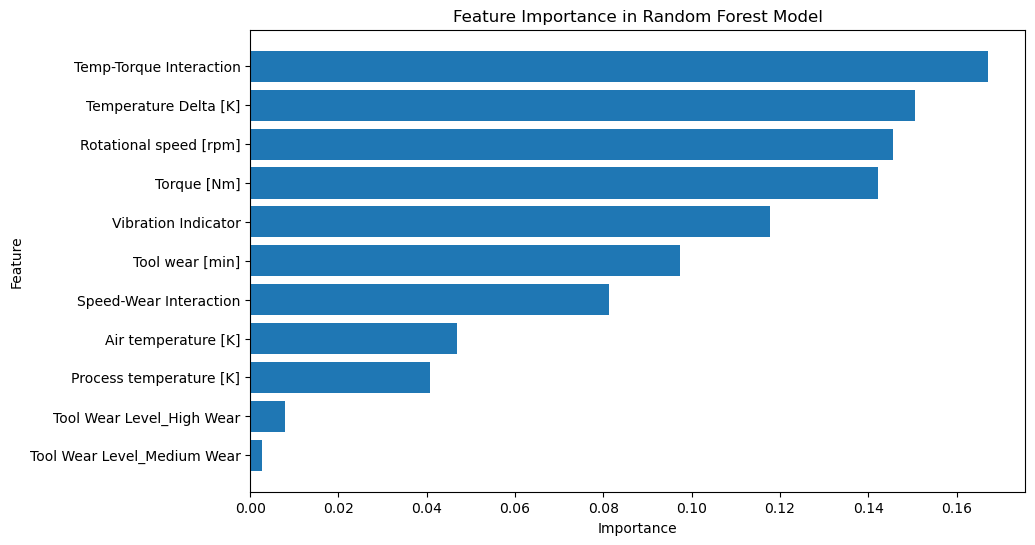

In [23]:
import matplotlib.pyplot as plt

# Train Random Forest model on the full ai4i_2020 dataset
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Extract feature importances and sort them
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

In [ ]:
Perform Hyperparameter Tuning with GridSearchCV

In [29]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load and prepare data
# Assuming 'data_encoded' is the preprocessed dataset with feature engineering applied
X = data_encoded.drop('Machine failure', axis=1)
y = data_encoded['Machine failure']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42, is_unbalance=True)

# Define the hyperparameter grid for tuning
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300]
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score as evaluation metric due to class imbalance
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Perform the grid search on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7729, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 15458, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 300, 'num_leaves': 70}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.76      0.74      0.75        68

    accuracy                           0.98      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.98

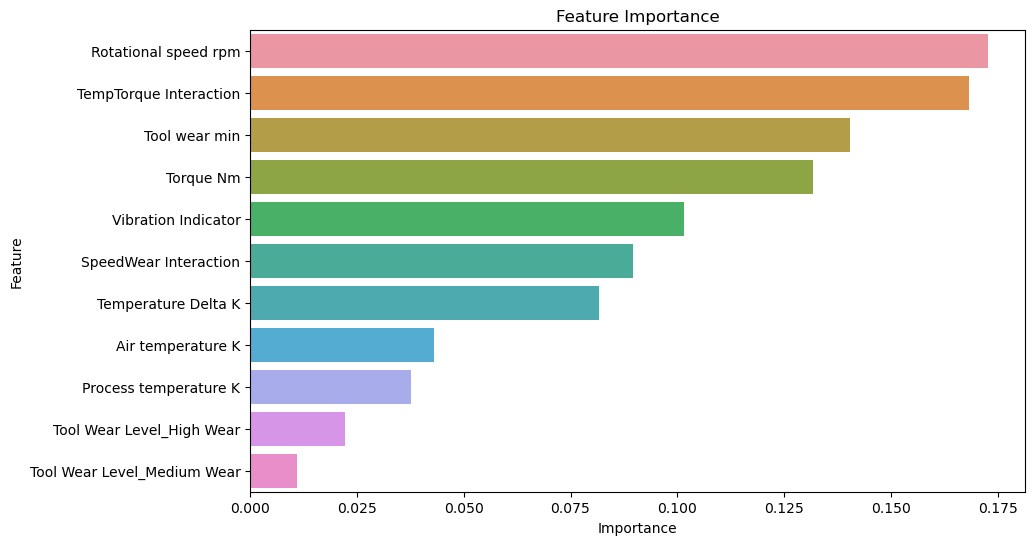

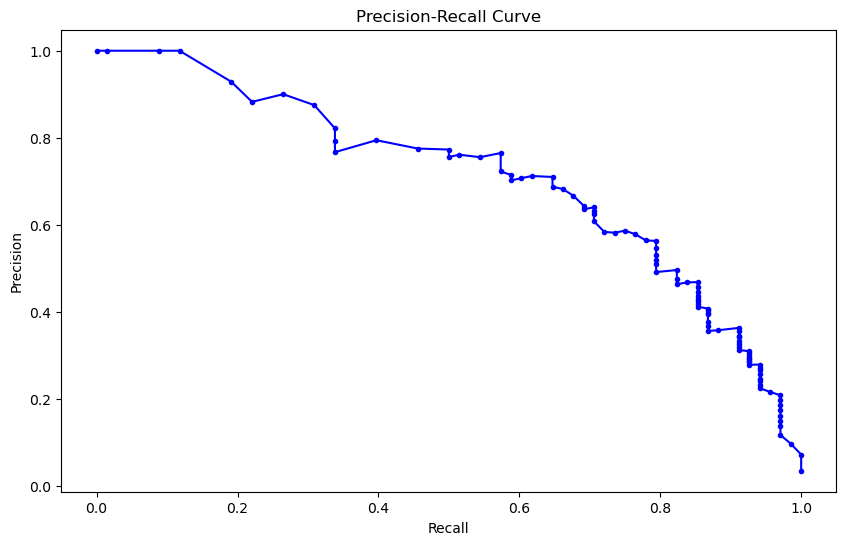

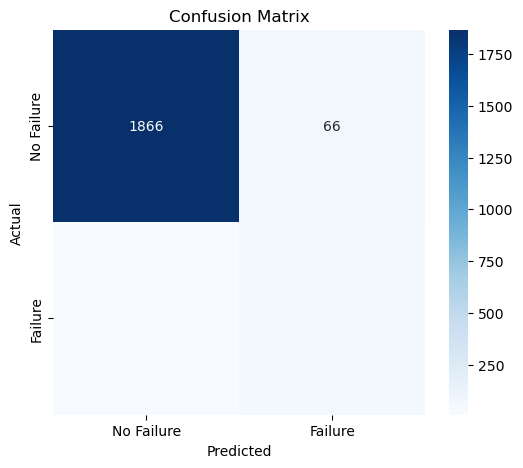

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.47      0.85      0.60        68

    accuracy                           0.96      2000
   macro avg       0.73      0.91      0.79      2000
weighted avg       0.98      0.96      0.97      2000



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Assuming 'data_encoded' is your dataset with necessary preprocessing completed
X = data_encoded.drop('Machine failure', axis=1)
y = data_encoded['Machine failure']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest model (or replace with best_model if LightGBM is available)
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 1. Feature Importance Graph
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 2. Precision-Recall Curve
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# 3. Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optional: Print classification report for additional insights
print("Classification Report:\n", classification_report(y_test, y_pred))

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd

# Load the saved model
model = joblib.load('lightgbm_model.joblib')

# Initialize FastAPI
app = FastAPI()

# Define a request body structure
class SensorData(BaseModel):
    air_temperature: float
    process_temperature: float
    rotational_speed: float
    torque: float
    tool_wear: float
    temperature_delta: float
    vibration_indicator: float
    temp_torque_interaction: float
    speed_wear_interaction: float
    tool_wear_level_LowWear: int
    tool_wear_level_MediumWear: int

# Define the prediction endpoint
@app.post("/predict_failure")
async def predict_failure(data: SensorData):
    try:
        # Convert incoming JSON data to DataFrame
        input_data = pd.DataFrame([data.dict()])

        # Make a prediction
        prediction = model.predict(input_data)[0]

        # Trigger alert if a failure is predicted
        alert_message = "ALERT: Potential failure detected!" if prediction == 1 else "No failure detected."
        
        return {"failure_prediction": int(prediction), "alert_message": alert_message}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

import requests

# Define the sample input data
sample_data = {
    "air_temperature": 300.1,
    "process_temperature": 310.2,
    "rotational_speed": 1500,
    "torque": 45.0,
    "tool_wear": 120,
    "temperature_delta": 10.1,
    "vibration_indicator": 67500,
    "temp_torque_interaction": 13959,
    "speed_wear_interaction": 180000,
    "tool_wear_level_LowWear": 1,
    "tool_wear_level_MediumWear": 0
}

# Send POST request to the API
response = requests.post("http://127.0.0.1:8000/predict_failure", json=sample_data)
print(response.json())